In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [8]:
dataset_dir = '/content/drive/MyDrive/Dataset/Facial dataset/CK+'


In [9]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

image_size = (48, 48)  # Resize images to 48x48 pixels
num_classes = 3  # Number of classes (Positive, Negative, Neutral)

# Initialize lists to store images and labels
images = []
labels = []

# Define the mapping of folder names to labels
emotion_label_map = {
    'happy': 0,       # Positive
    'surprise': 0,    # Positive
    'anger': 1,       # Negative
    'sadness': 1,     # Negative
    'contempt': 2,    # Neutral
    'disgust': 2,     # Neutral
    'fear': 2         # Neutral
}

# Read dataset folder and process images
for sub_folder in os.listdir(dataset_dir):
    if sub_folder in emotion_label_map:  # Ensure the folder corresponds to a valid emotion
        new_label = emotion_label_map[sub_folder]  # Get the mapped label
        sub_folder_path = os.path.join(dataset_dir, sub_folder)

        # Read all images in the subfolder
        for img_file in os.listdir(sub_folder_path):
            img_path = os.path.join(sub_folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            if img is not None:  # Ensure the image is valid
                img = cv2.resize(img, image_size)  # Resize to 48x48
                images.append(img)
                labels.append(new_label)

# Convert lists to NumPy arrays
X = np.array(images, dtype='float32')
y = np.array(labels, dtype='int')

# Normalize image data
X = X / 255.0  # Normalize pixel values to [0, 1]

# Reshape images for CNN input (48x48x1 for grayscale images)
X = np.expand_dims(X, axis=-1)

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=num_classes)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (784, 48, 48, 1)
y_train shape: (784, 3)
X_test shape: (197, 48, 48, 1)
y_test shape: (197, 3)


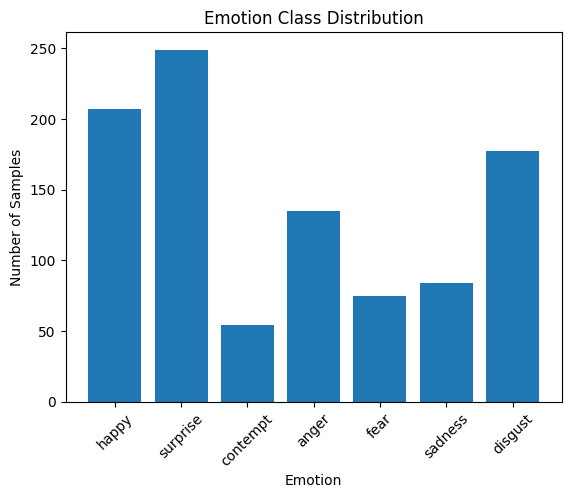

In [10]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(dataset_path):
    labels = []
    for emotion in os.listdir(dataset_path):
        emotion_folder = os.path.join(dataset_path, emotion)
        if not os.path.isdir(emotion_folder):
            continue
        labels.extend([emotion] * len(os.listdir(emotion_folder)))

    emotion_counts = Counter(labels)
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title("Emotion Class Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()

dataset_path = '/content/drive/MyDrive/Dataset/Facial dataset/CK+'
plot_class_distribution(dataset_path)


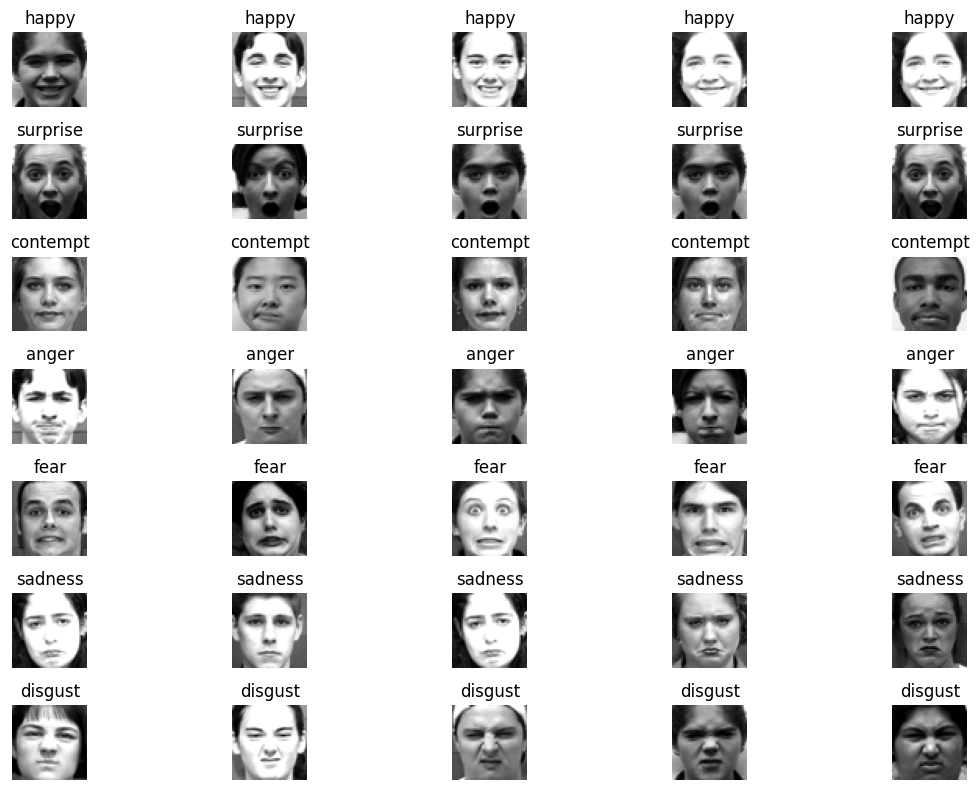

In [11]:
import cv2
import numpy as np

def display_sample_images(dataset_path, sample_per_class=5):
    plt.figure(figsize=(12, 8))
    emotion_folders = [os.path.join(dataset_path, e) for e in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, e))]

    for idx, emotion_folder in enumerate(emotion_folders):
        emotion_name = os.path.basename(emotion_folder)
        image_files = os.listdir(emotion_folder)[:sample_per_class]

        for i, img_file in enumerate(image_files):
            img_path = os.path.join(emotion_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))  # Resize for uniformity
            plt.subplot(len(emotion_folders), sample_per_class, idx * sample_per_class + i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(emotion_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(dataset_path)


In [27]:
def analyze_image_properties(dataset_path):
    widths, heights = [], []
    for emotion in os.listdir(dataset_path):
        emotion_folder = os.path.join(dataset_path, emotion)
        if not os.path.isdir(emotion_folder):
            continue

        for img_file in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            h, w = img.shape
            widths.append(w)
            heights.append(h)

    print(f"Image Widths: Min={min(widths)}, Max={max(widths)}, Mean={np.mean(widths):.2f}")
    print(f"Image Heights: Min={min(heights)}, Max={max(heights)}, Mean={np.mean(heights):.2f}")

analyze_image_properties(dataset_path)


Image Widths: Min=48, Max=48, Mean=48.00
Image Heights: Min=48, Max=48, Mean=48.00


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

# CNN Architecture
input = Input(shape=(48, 48, 1))  # Grayscale images of size 48x48

conv1 = Conv2D(32, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)
dense_1 = Dense(128, activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(3, activation="softmax")(drop_1)  # 3 classes, use 'softmax'

# Define and compile the model
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

# Configure Model Checkpoint
checkpoint_path = './output/emotion_model.h5'
checkpointer = ModelCheckpoint(
    checkpoint_path,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

# Callback list
callback_list = [checkpointer]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=callback_list
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 dropout_10 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                           

In [25]:
save = history

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

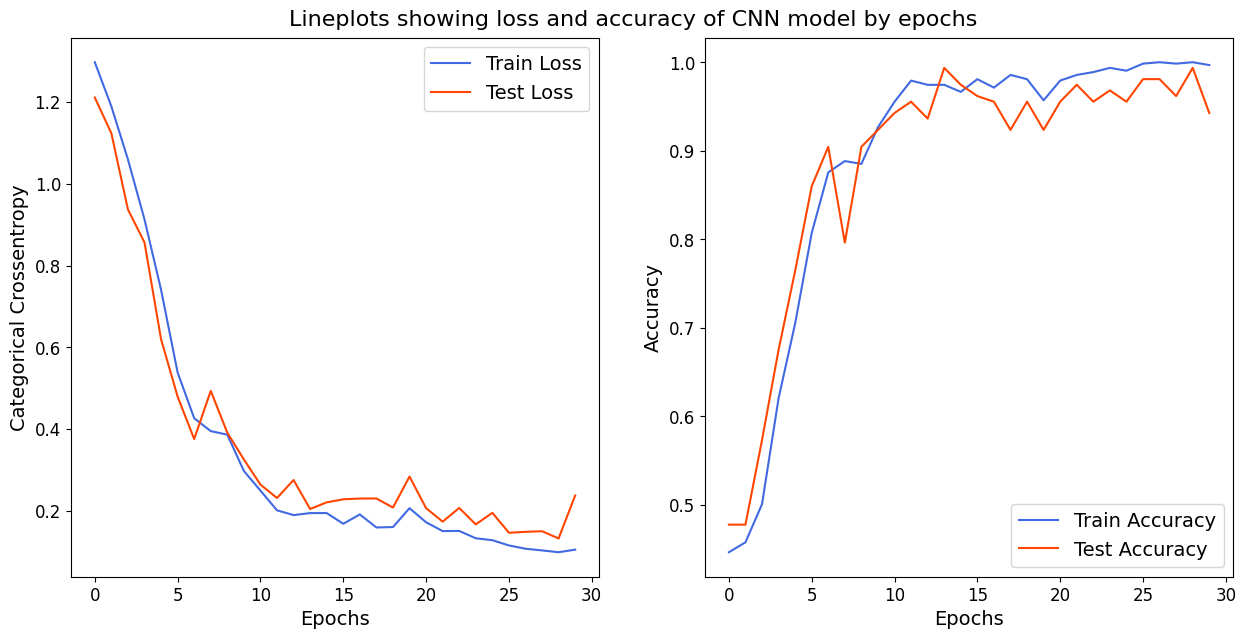

In [39]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


In [34]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model and label mappings
model = load_model("/content/output/emotion_model.h5")
label = np.array(["happy", "sad", "neutral"])  # Adjust based on your classes

# Preprocessing function
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Image not loaded correctly from {image_path}")

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image to match the model input size (48x48)
    img = cv2.resize(img, (48, 48))

    # Normalize the pixel values (0 to 1)
    img = img.astype("float32") / 255.0

    # Expand dimensions to match (1, 48, 48, 1)
    img = np.expand_dims(img, axis=-1)  # Add the channel dimension
    img = np.expand_dims(img, axis=0)   # Add the batch dimension

    return img

# Prediction function
def predict_emotion(image_path):
    img = preprocess_image(image_path)

    # Predict emotion
    predicted_class = np.argmax(model.predict(img))

    return label[predicted_class]

# Test the function with a new image
image_path = "/content/happy.jpg"  # Replace with the path to your new image
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")


1/1 [==============================] - 0s 84ms/step
Predicted Emotion: happy


1/1 [==============================] - 0s 93ms/step


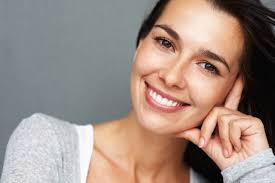

Predicted Emotion: happy


In [38]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow  # Import for displaying images in Colab

# Load the trained model and label mappings
model = load_model("/content/output/emotion_model.h5")
label = np.array(["happy", "sad", "neutral"])  # Adjust based on your classes

# Preprocessing function
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Image not loaded correctly from {image_path}")

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image to match the model input size (48x48)
    img_resized = cv2.resize(img_gray, (48, 48))

    # Normalize the pixel values (0 to 1)
    img_resized = img_resized.astype("float32") / 255.0

    # Expand dimensions to match (1, 48, 48, 1)
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add the channel dimension
    img_resized = np.expand_dims(img_resized, axis=0)   # Add the batch dimension

    return img_resized, img

# Prediction function
def predict_emotion(image_path):
    img_resized, img = preprocess_image(image_path)

    # Predict emotion
    predicted_class = np.argmax(model.predict(img_resized))
    predicted_emotion = label[predicted_class]

    # Display the image with the prediction using cv2_imshow for Colab
    cv2_imshow(img)  # Use cv2_imshow instead of cv2.imshow() in Colab
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return predicted_emotion

# Test the function with a new image
image_path = "/content/happy.jpg"  # Replace with the path to your new image
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")


1/1 [==============================] - 0s 24ms/step


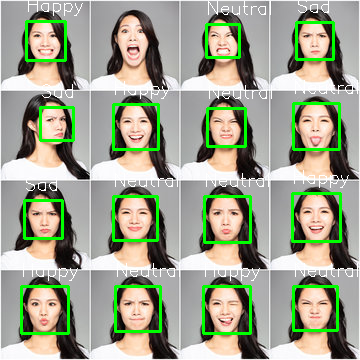

In [14]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow  # For Colab image display

# Load pre-trained model and labels
model = load_model("/content/model.h5")  # Replace with your model's path
labels_dict = {0: "Happy", 1: "Sad", 2: "Neutral"}  # Modify based on your labels

# Load the image
image_path = "/content/Multiple faces.jpg"  # Replace with your image's path
frame = cv2.imread(image_path)


# Convert to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Load Haarcascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

# Process each face
for x, y, w, h in faces:
    sub_face_img = gray[y:y+h, x:x+w]  # Extract face region
    resized = cv2.resize(sub_face_img, (48, 48))  # Resize to model input size
    normalize = resized / 255.0  # Normalize pixel values
    reshaped = np.reshape(normalize, (1, 48, 48, 1))  # Add batch and channel dimensions

    # Predict emotion
    result = model.predict(reshaped)
    label = np.argmax(result, axis=1)[0]

    # Annotate the image
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Draw green rectangle
    cv2.putText(frame, labels_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)  # Smaller text

# Display the annotated image
cv2_imshow(frame)


1/1 [==============================] - 0s 26ms/step


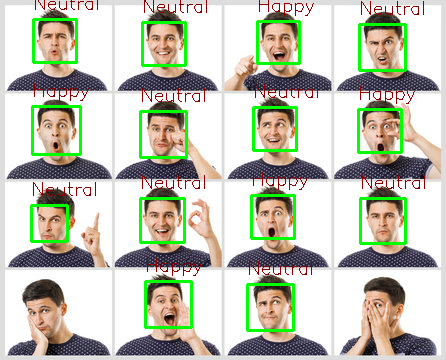

In [25]:
import cv2
import numpy as np
from keras.models import load_model
from google.colab.patches import cv2_imshow  # For Colab image display

# Load pre-trained model and labels
model = load_model("/content/model.h5")  # Replace with your model's path
labels_dict = {0: "Happy", 1: "Sad", 2: "Neutral"}  # Modify based on your labels

# Load the image
image_path = "/content/Multiple faces.jpg"  # Replace with your image's path
frame = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Load Haarcascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Detect all faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

# Iterate over all detected faces
for (x, y, w, h) in faces:
    sub_face_img = gray[y:y+h, x:x+w]  # Extract face region
    resized = cv2.resize(sub_face_img, (48, 48))  # Resize to model input size
    normalize = resized / 255.0  # Normalize pixel values
    reshaped = np.reshape(normalize, (1, 48, 48, 1))  # Add batch and channel dimensions

    # Predict emotion for the detected face
    result = model.predict(reshaped)
    label = np.argmax(result, axis=1)[0]  # Get the emotion label index

    # Draw a rectangle around the face
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

    # Choose a darker color for the text (dark blue in this case)
    text_color = (0, 0, 139)

    # Overlay the emotion label text above the face
    cv2.putText(frame, labels_dict[label], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1)  # Smaller text with dark color

# Display the annotated image
cv2_imshow(frame)


In [3]:
import os
import numpy as np
from keras.models import load_model
from PIL import Image

# Load pre-trained model and labels
model = load_model("/content/model.h5")  # Replace with the actual path to your model

# Music recommendations based on emotions
music_recommendations = {
    "happy": ["Happy Song 1 - Artist A", "Happy Song 2 - Artist B", "Happy Song 3 - Artist C"],
    "sad": ["Sad Song 1 - Artist D", "Sad Song 2 - Artist E", "Sad Song 3 - Artist F"],
    "neutral": ["Neutral Song 1 - Artist G", "Neutral Song 2 - Artist H", "Neutral Song 3 - Artist I"],
}

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')  # Convert to grayscale (L mode)
    img = img.resize((48, 48))  # Resize to fit the model input size
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension for grayscale (48, 48, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image to [0, 1]
    return img_array

# Function to predict the emotion label from the image
def predict_image_label(image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    label = np.argmax(prediction, axis=1)[0]  # Get the index of the class with the highest probability
    return label

# Map predicted labels to music recommendations
def get_music_recommendations(label):
    if label == 0:
        return music_recommendations["happy"]
    elif label == 1:
        return music_recommendations["sad"]
    else:
        return music_recommendations["neutral"]

# Main function to process the image and print music recommendations
def main():
    image_path = "/content/happy.jpg"  # Replace with the path to the image you want to process

    # Predict the emotion label for the uploaded image
    label = predict_image_label(image_path)

    # Get music recommendations based on the predicted emotion label
    recommendations = get_music_recommendations(label)

    # Print the music recommendations
    print("Recommended Music:")
    for song in recommendations:
        print(song)

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Recommended Music:
Happy Song 1 - Artist A
Happy Song 2 - Artist B
Happy Song 3 - Artist C


In [6]:
from google.colab import output
from IPython.display import display, Javascript
from base64 import b64decode
import io
from PIL import Image
import time

# Function to capture an image from the webcam
def capture_image():
    display(Javascript("""
        const video = document.createElement('video');
        video.setAttribute('autoplay', true);
        video.setAttribute('width', '640');
        video.setAttribute('height', '480');
        document.body.appendChild(video);

        // Access the webcam
        navigator.mediaDevices.getUserMedia({ video: true })
            .then(stream => {
                video.srcObject = stream;

                // Capture image after 6 seconds
                setTimeout(() => {
                    const canvas = document.createElement('canvas');
                    canvas.width = 640;
                    canvas.height = 480;
                    const context = canvas.getContext('2d');
                    context.drawImage(video, 0, 0, canvas.width, canvas.height);

                    // Convert to data URL and send to Python
                    const dataUrl = canvas.toDataURL('image/jpeg');
                    google.colab.kernel.invokeFunction('notebook.capture_image', [dataUrl], {});

                    // Stop video stream
                    stream.getTracks().forEach(track => track.stop());
                }, 6000);  // Capture after 6 seconds
            })
            .catch(err => {
                console.log("Error accessing the webcam: ", err);
            });
    """))

# Python callback to handle the captured image data
def handle_captured_image(data_url):
    # Convert base64 data to image
    image_data = b64decode(data_url.split(',')[1])
    image = Image.open(io.BytesIO(image_data))

    # Save image to variable
    captured_image = image

    # Optionally, save the image to a file
    captured_image.save("/content/captured_image.jpg")

    # Display the captured image
    captured_image.show()
    print("Image captured and displayed successfully.")

# Register the callback for image capture
output.register_callback('notebook.capture_image', handle_captured_image)

# Trigger the webcam capture process
capture_image()


<IPython.core.display.Javascript object>

Image captured and displayed successfully.


In [7]:
import os
import numpy as np
from keras.models import load_model
from PIL import Image

# Load pre-trained model and labels
model = load_model("/content/model.h5")  # Replace with the actual path to your model

# Music recommendations based on emotions
music_recommendations = {
    "happy": ["Happy Song 1 - Artist A", "Happy Song 2 - Artist B", "Happy Song 3 - Artist C"],
    "sad": ["Sad Song 1 - Artist D", "Sad Song 2 - Artist E", "Sad Song 3 - Artist F"],
    "neutral": ["Neutral Song 1 - Artist G", "Neutral Song 2 - Artist H", "Neutral Song 3 - Artist I"],
}

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')  # Convert to grayscale (L mode)
    img = img.resize((48, 48))  # Resize to fit the model input size
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension for grayscale (48, 48, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image to [0, 1]
    return img_array

# Function to predict the emotion label from the image
def predict_image_label(image_path):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    label = np.argmax(prediction, axis=1)[0]  # Get the index of the class with the highest probability
    return label

# Map predicted labels to music recommendations
def get_music_recommendations(label):
    if label == 0:
        return music_recommendations["happy"]
    elif label == 1:
        return music_recommendations["sad"]
    else:
        return music_recommendations["neutral"]

# Main function to process the image and print music recommendations
def main():
    image_path = "/content/captured_image.jpg"  # Replace with the path to the image you want to process

    # Predict the emotion label for the uploaded image
    label = predict_image_label(image_path)

    # Get music recommendations based on the predicted emotion label
    recommendations = get_music_recommendations(label)

    # Print the music recommendations
    print("Recommended Music:")
    for song in recommendations:
        print(song)

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Recommended Music:
Neutral Song 1 - Artist G
Neutral Song 2 - Artist H
Neutral Song 3 - Artist I


In [ ]:
openaikey = ""

In [ ]:
HF_Key = ""

In [ ]:
import requests

# Set up API endpoint and parameters
api_key = ''
tag = 'happy'
url = f"http://ws.audioscrobbler.com/2.0/?method=tag.gettoptracks&tag={tag}&api_key={api_key}&format=json"

# Send GET request to Last.fm API
response = requests.get(url)

# Parse the response
if response.status_code == 200:
    data = response.json()
    top_tracks = data['tracks']['track']
    for idx, track in enumerate(top_tracks[:5]):
        print(f"Recommendation {idx+1}: {track['name']} by {track['artist']['name']}")
else:
    print("Error fetching data.")


Recommendation 1: Pumped Up Kicks by Foster the People
Recommendation 2: Hey Ya! by OutKast
Recommendation 3: Dog Days Are Over by Florence + the Machine
Recommendation 4: Friday I'm in Love by The Cure
Recommendation 5: I'm Yours by Jason Mraz


In [ ]:
last.fm = ''

In [ ]:
import requests
import urllib.parse

# Set up API endpoint and parameters
api_key = ''  # Your Last.fm API key
tag = 'happy'  # Mood/Tag to filter songs by
url = f"http://ws.audioscrobbler.com/2.0/?method=tag.gettoptracks&tag={tag}&api_key={api_key}&format=json"

# Send GET request to Last.fm API
response = requests.get(url)

# Parse the response
if response.status_code == 200:
    data = response.json()
    top_tracks = data['tracks']['track']

    # Generate a list of song and artist names
    songs = [f"{track['name']} by {track['artist']['name']}" for track in top_tracks[:5]]

    # Display the top 5 recommended songs
    for idx, song in enumerate(songs):
        print(f"Recommendation {idx+1}: {song}")

    # Function to generate YouTube search links based on song and artist
    def generate_youtube_links(songs):
        youtube_links = []
        for song in songs:
            # URL encode the song and artist string
            encoded_query = urllib.parse.quote_plus(song)

            # Generate the YouTube search URL
            youtube_url = f"https://www.youtube.com/results?search_query={encoded_query}"

            youtube_links.append(youtube_url)

        return youtube_links

    # Generate YouTube links
    youtube_links = generate_youtube_links(songs)

    # Display the YouTube links
    for i, link in enumerate(youtube_links, 1):
        print(f"Recommendation {i} YouTube Link: {link}")

else:
    print("Error fetching data from Last.fm.")


Recommendation 1: Pumped Up Kicks by Foster the People
Recommendation 2: Hey Ya! by OutKast
Recommendation 3: Dog Days Are Over by Florence + the Machine
Recommendation 4: Friday I'm in Love by The Cure
Recommendation 5: I'm Yours by Jason Mraz
Recommendation 1 YouTube Link: https://www.youtube.com/results?search_query=Pumped+Up+Kicks+by+Foster+the+People
Recommendation 2 YouTube Link: https://www.youtube.com/results?search_query=Hey+Ya%21+by+OutKast
Recommendation 3 YouTube Link: https://www.youtube.com/results?search_query=Dog+Days+Are+Over+by+Florence+%2B+the+Machine
Recommendation 4 YouTube Link: https://www.youtube.com/results?search_query=Friday+I%27m+in+Love+by+The+Cure
Recommendation 5 YouTube Link: https://www.youtube.com/results?search_query=I%27m+Yours+by+Jason+Mraz


# Thank you